In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Tasks

* Cap sizes and update zero padding
* Embeddding layer first 
* Specify size of image as input to embedding (later)


In [17]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import gc

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0-beta1


## Get training and validation set

In [18]:
from src.utils import read_shapefile
from sklearn.model_selection import train_test_split
from config import raw_data_dir

train_shp_df = read_shapefile('train')
test_shp_df = read_shapefile('test')

# Labels must be zero indexed
train_shp_df['Crop_Id_Ne'] = train_shp_df['Crop_Id_Ne'].astype(int) - 1

train_shp_df.head()

,Area,Subregion,Crop_Id_Ne,geometry
Field_Id,,,,
1,0.915905,3,7,"POLYGON ((613924.3324000851 6793991.295069702,..."
2,2.064410,3,5,"POLYGON ((614404.0717397591 6794020.579634549,..."
3,1.080300,3,7,"POLYGON ((614320.2146632321 6793964.242091182,..."
4,1.316190,3,7,"POLYGON ((614560.5326844405 6794002.249461887,..."
7,5.529220,3,7,"POLYGON ((614596.6564746551 6794269.865436315,..."


In [19]:
class_names = pd.read_csv(os.path.join(raw_data_dir, 'crop_id_list.csv'))
class_names.crop_id = class_names.crop_id.astype(int) - 1
class_names = class_names.set_index('crop_id')

class_names

,crop
crop_id,
0,Cotton
1,Dates
2,Grass
3,Lucern
4,Maize
5,Pecan
6,Vacant
7,Vineyard
8,"Vineyard & Pecan (""Intercrop"")"


### Setup training and validation data

In [20]:
# Get Farm IDs and labels of train and validation sets
train_ids, val_ids, train_labels, val_labels = train_test_split(train_shp_df.index, train_shp_df['Crop_Id_Ne'], test_size=0.3, stratify=train_shp_df['Crop_Id_Ne'])

# Create lists of farm ids
train_ids_list = train_ids.to_list()
val_ids_list = val_ids.to_list()

train_ids.shape, train_labels.shape, val_ids.shape, val_labels.shape

((1745,), (1745,), (749,), (749,))

In [21]:
# Check that labels index and ids list is the same
sorted(list(train_labels.index)) == sorted(train_ids_list)

True

### Setup testing set in similar way

In [22]:
test_ids = test_shp_df.index
test_ids_list = test_ids.to_list()

## Read satellite data for one dump, and one spectral band

In [23]:
import os
from glob import glob
from config import interim_data_dir

date = '2017-01-01'
band = 'B05'

# Get list of images filepaths
train_images_all = glob(os.path.join(interim_data_dir, 'masks', 'train', date, f'*_{band}.npy'))
test_images = glob(os.path.join(interim_data_dir, 'masks', 'test', date, f'*_{band}.npy'))

# Load images
# Train gets split into train and validation
train_imgs = [np.load(f) for f in train_images_all if int(os.path.basename(f).split('.')[0].split('_')[1]) in train_ids_list]
val_imgs = [np.load(f) for f in train_images_all if int(os.path.basename(f).split('.')[0].split('_')[1]) in val_ids_list]

# All test gets loaded
test_imgs = [np.load(f) for f in test_images]

## Analyse Max of widths and heights

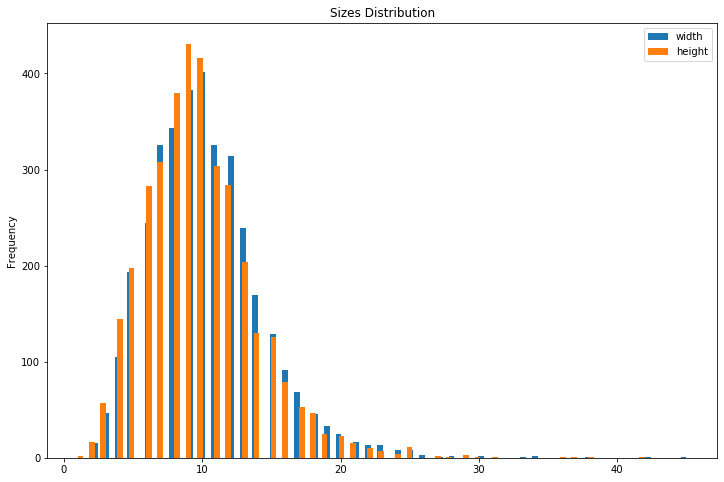

In [24]:
import pandas as pd
from operator import itemgetter

all_images = train_imgs + val_imgs + test_imgs
all_ids = train_ids_list + val_ids_list + test_ids_list

shapes = {id: x.shape for  id,x in zip(all_ids, all_images)}

widths = [x[0] for x in shapes.values()]
heights = [x[1] for x in shapes.values()]

w_plot = pd.Series(widths).plot.hist(bins=100, title='Sizes Distribution', label='width', figsize=(12,8))
h_plot = pd.Series(heights).plot.hist(bins=100, title='Sizes Distribution', label='height', figsize=(12,8))
plt.legend()
display(w_plot)
display(h_plot)

**Insight**

Seems like very few images below 30 x 30

In [25]:
MAX_DIMS = (30, 30)

# Get number of farms with dims more than max
N_large = len([x for x in train_imgs + val_imgs + test_imgs if (x.shape[0] > MAX_DIMS[0]  or x.shape[1] > MAX_DIMS[1])])
print('{} farms have width or height > max value'.format(N_large))

7 farms have width or height > max value


### Show farms IDs that are larger than max dims

In [30]:
large_farm_ids_in_train = []
for id, s in shapes.items():
    if s[0] > MAX_DIMS[0] or s[1] > MAX_DIMS[0]:
        in_train = id in train_ids_list
        in_test = id in test_ids_list
        
        if in_train:
            print(id, s, 'in train')
            large_farm_ids_in_train.append(id)
        else:
            print(id, s, 'in test')

459 (42, 42) in train
2592 (33, 31) in train
3396 (45, 37) in test
2471 (16, 36) in test
3498 (34, 22) in test
3036 (38, 38) in test
1740 (34, 22) in test


In [31]:
# I chose a large farm in training set
FARM_IDX = large_farm_ids_in_train[0]

## Normalize and zero-pad all images

### Normalization

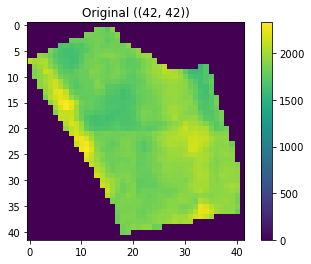

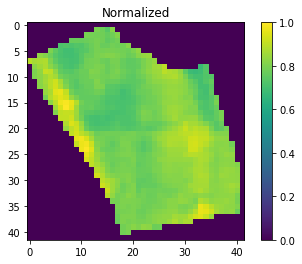

In [32]:
def normalize_img(img, max_val=1, min_val=0):
    img_max = np.max(img)
    img_min = np.min(img)
    img_std = (img - img_min) / (img_max - img_min)
    return img_std * (max_val - min_val) + min_val

plt.figure()
img = train_imgs[train_ids_list.index(FARM_IDX)]
plt.title('Original ({})'.format(img.shape))
plt.imshow(img)
plt.colorbar()
plt.grid(False)
plt.show()

plt.figure()
plt.title('Normalized')
plt.imshow(normalize_img(img))
plt.colorbar()
plt.grid(False)
plt.show()

Looks good!




In [33]:
import cv2

def zero_pad_mask(img, shape):
    """
    TODO: Parameterize anchoring
    
    :param img:
    :param shape:
    :return:
    """
    
    # If the image has width > max width, crop to max width
    if img.shape[0] > shape[0]:
        img = img[:shape[0],:]
    
    # If the image has height > max height, crop to max height
    if img.shape[1] > shape[1]:
        img = img[:, :shape[1]]
    
    # Size of border
    v_border = int(np.ceil((shape[0] - img.shape[0]) / 2))
    h_border = int(np.ceil((shape[1] - img.shape[1]) / 2))

    v_diff = shape[0] - (img.shape[0] + 2 * v_border)
    h_diff = shape[1] - (img.shape[1] + 2 * h_border)

    new_img = cv2.copyMakeBorder(
        img,
        top=v_border, bottom=v_border + v_diff,
        left=h_border, right=h_border + h_diff,
        borderType=cv2.BORDER_CONSTANT, value=0
    )

    assert new_img.shape == shape, 'zero padding issue'

    return new_img

### Example of zero-padded farm

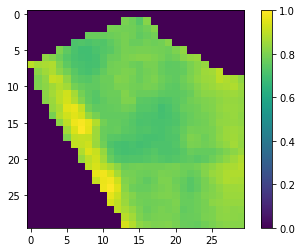

In [34]:
img_norm = normalize_img(img)
zp_img = zero_pad_mask(img_norm, shape=MAX_DIMS)

plt.figure()
plt.imshow(zp_img)
plt.colorbar()
plt.grid(False)
plt.show()

Looks good! - the width was cropped. But this will only happen to 6 images

### Process all images

In [44]:
def process_img(img):
    return zero_pad_mask(normalize_img(img), shape=MAX_DIMS)

train_data = np.array(list(map(process_img, train_imgs))).reshape(-1, *MAX_DIMS, 1)
val_data = np.array(list(map(process_img, val_imgs))).reshape(-1, *MAX_DIMS, 1)
test_data = np.array(list(map(process_img, test_imgs))).reshape(-1, *MAX_DIMS, 1)

/Users/renier.botha/anaconda3/envs/zindi_farmpin/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [45]:
print('Train data:\t\t', train_data.shape)
print('Validation data:\t',val_data.shape)
print('Test data:\t\t',test_data.shape)

Train data:		 (1745, 30, 30, 1)
Validation data:	 (749, 30, 30, 1)
Test data:		 (1074, 30, 30, 1)


## Examples of images before transformation

In [46]:
random_list = np.random.choice(train_ids_list, size=25)

/Users/renier.botha/anaconda3/envs/zindi_farmpin/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


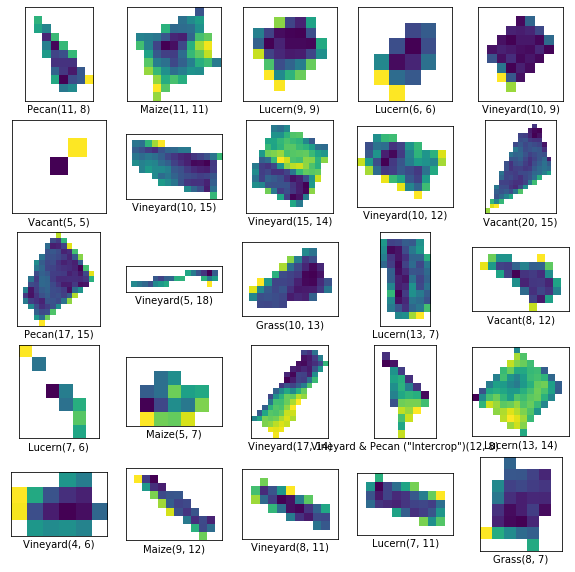

In [47]:
plt.figure(figsize=(10,10))
for i, farm_id in enumerate(random_list):
    
    # Index of this farm in the list of IDs
    idx = train_ids_list.index(farm_id)
    
    # Label of farm (0-9)
    label = train_labels.loc[farm_id]
    
    # Class name ('vinyard', etc)
    class_name = class_names.loc[int(label)].crop
    
    img = train_imgs[idx]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.log10(img))
    plt.xlabel(class_name + f'{img.shape}')
    
plt.show()

/Users/renier.botha/anaconda3/envs/zindi_farmpin/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


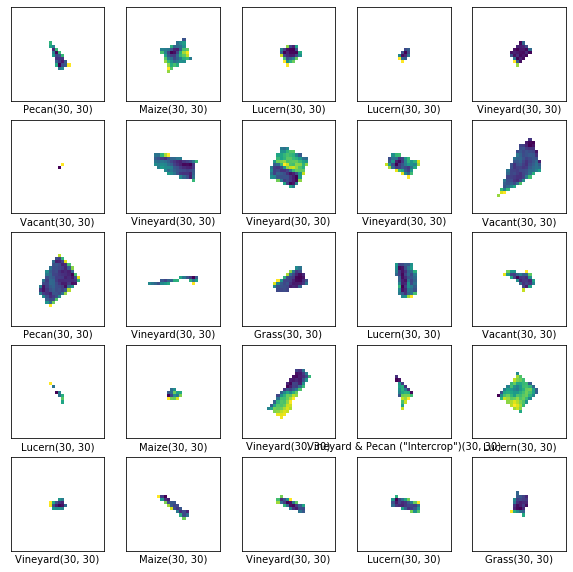

In [51]:
plt.figure(figsize=(10,10))
for i, farm_id in enumerate(random_list):
    
    idx = train_ids_list.index(farm_id)
    label = train_labels.loc[farm_id]
    class_name = class_names.loc[int(label)].crop
    
    img = train_data[idx][:, :, 0]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.log10(img))
    plt.xlabel(class_name + f'{img.shape}')
    
plt.show()

## Build Model 

In [52]:
from tensorflow.keras import models, layers

In [53]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(30, 30, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

In [54]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [55]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=[keras.metrics.categorical_accuracy])

model.fit(train_data, 
          train_labels,
          batch_size=64,
          validation_data=(val_data, val_labels), 
          verbose=2,
          epochs=10)

W0714 16:14:55.896011 4694853056 deprecation.py:323] From /Users/renier.botha/anaconda3/envs/zindi_farmpin/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1745 samples, validate on 749 samples
Epoch 1/10
1745/1745 - 1s - loss: nan - categorical_accuracy: 0.9759 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 2/10
1745/1745 - 1s - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 3/10
1745/1745 - 1s - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 4/10
1745/1745 - 1s - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 5/10
1745/1745 - 1s - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 6/10
1745/1745 - 1s - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 7/10


KeyboardInterrupt: 

In [ ]:
model.predict_proba(val_data[:2])

In [ ]:
train_data[:2].shape